In [73]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.datasets import make_classification

%matplotlib inline

# Prepare dataset

We generate same toy data set for learning.

In [103]:
dataset = make_classification(n_samples=10000, n_features=3, n_informative=3, n_redundant=0, weights=[0.9, 0.1])

df = pd.DataFrame({
        'feature1': dataset[0][:, 0], 
        'feature2': dataset[0][:, 1], 
        'feature3': dataset[0][:, 2],
        'target': dataset[1]
})

df.head()

,feature1,feature2,feature3,target
0,0.752457,0.481068,0.105942,0
1,-1.988784,-0.449766,-3.462028,0
2,1.856330,1.181396,2.798389,0
3,1.245103,1.361400,1.617205,0
4,-1.843974,-0.471203,-1.927955,0


We see imbalanced class. For our purpose, we select online two class 6 and 7.

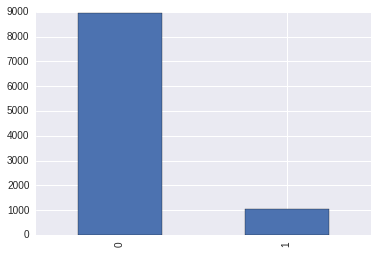

In [105]:
df.target.value_counts().plot(kind='bar')

In [108]:
df.target.value_counts()

0    8958
1    1042
Name: target, dtype: int64

## Modeling without dealing with imbalanced data

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('target', axis=1), df.target, train_size=0.8, random_state=42
)

In [127]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [128]:
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred, labels=[0, 1])

array([[1773,    2],
       [ 218,    7]])

In [129]:
roc_auc_score(y_test, y_pred)

0.51499217527386543

We can use class_weight parameter, but we want to learn new method for imbalanced data.

## Class weight in Scikit learn

In [252]:
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred, labels=[0, 1])

array([[1222,  553],
       [  77,  148]])

In [249]:
roc_auc_score(y_test, y_pred)

0.67311424100156492

### How it works

It is inversely proportional to the number of samples in the class.

You can compute old way.

In [234]:
classes = y_train.unique().tolist()
classes

[1, 0]

In [235]:
bincounts = np.bincount(y_train)
bincounts

array([7183,  817])

In [236]:
recip_freq = 1.0 / bincounts
recip_freq

array([ 0.00013922,  0.00122399])

In [237]:
weights = recip_freq / np.mean(recip_freq)
weights

array([ 0.20425,  1.79575])

Or new way. Based on Logistic Regression in Rare Events Data, King, Zen, 2001.

In [243]:
weights = len(y_train) / (len(classes) * np.bincount(y_train).astype(float))
weights

array([ 0.55687039,  4.89596083])

Basically, it changes regularized parameter of C.

weights[i] * C

# Undersampling

We distinguish two undersampling methods: informative and random. Informative undersampling are Easy Ensemble and Balance Cascade. In random undersampling we remove observations from majority class.

## Easy Ensemble

We need to get several subsets of independend sample. It means, that you need to take sample with replacement from majority class.

In [148]:
minority_df = df[df.target == 1]
majority_df_sample = df[df.target == 0].sample(minority_df.shape[0], random_state=42, replace=True)
majority_df_sample.shape

(1042, 4)

Now we can learn some classifiers.

In [223]:
estimators = []
idx = y_train[y_train == 1].index
X_pos = X_train.ix[idx]
y_pos = y_train.ix[idx]

for _ in range(10):
    idx = y_train[y_train == 0].sample(X_pos.shape[0], random_state=_, replace=True).index
    
    model = LogisticRegression() 
    model.fit(X_pos.append(X_train.ix[idx]), y_pos.append(y_train.ix[idx]))
    
    estimators.append(('model_{}'.format(_), model))

We get probabilities.

In [229]:
predictions = pd.DataFrame({'target': y_test})

for name, estimator in estimators:
    predictions[name] = estimator.predict_proba(X_test)[:, 1]

predictions['probability'] = np.mean(predictions.drop('target', axis=1), axis=1)
predictions['prediction'] = predictions.probability.map(lambda x: x >= 0.5).astype(int)
predictions.head()

,target,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,probability,prediction
6252,0,0.307361,0.328110,0.291386,0.330929,0.333173,0.315174,0.350887,0.312463,0.320279,0.327973,0.321773,0
4684,1,0.853364,0.834847,0.857103,0.814923,0.820279,0.843630,0.834913,0.866506,0.848302,0.841068,0.841494,1
1731,1,0.682669,0.679375,0.678795,0.656012,0.664683,0.680123,0.695668,0.699919,0.685484,0.683889,0.680662,1
4742,0,0.535665,0.514148,0.581165,0.506887,0.495448,0.536131,0.496213,0.515574,0.510016,0.497948,0.518920,1
4521,0,0.618364,0.582606,0.645839,0.582326,0.572311,0.604244,0.557317,0.613470,0.596398,0.580453,0.595333,1


In [230]:
confusion_matrix(y_test, predictions.prediction, labels=[0, 1])

array([[1221,  554],
       [  77,  148]])

In [231]:
roc_auc_score(y_test, y_pred)

0.67311424100156492

Result of this exercise is equal to result from weight class in Logistic Regression above.